In [ ]:
# 🌍 Data Preparation in Google Earth Engine (Steps 1–3)

This analysis begins with data pre-processing in **Google Earth Engine (GEE)** to prepare the core geospatial datasets used in the subsequent Python workflow.

### **Data Processing Summary (GEE)**

The following datasets were collected, clipped, and exported from GEE for the study area (AOI – Lao PDR province/district level):

| Dataset | Source | Resolution | Purpose |
|----------|---------|-------------|----------|
| **Digital Elevation Model (DEM)** | SRTM v3 (USGS/SRTMGL1_003) | 30 m | To derive elevation and identify low-lying (flood-prone) areas |
| **Land-Use/Land-Cover (LULC)** | ESA WorldCover v200 (2021) | 10 m | To classify land types and assign runoff coefficients |
| **Sentinel-2 Surface Reflectance** | COPERNICUS/S2_SR_HARMONIZED | 10 m | For computing NDVI/NDWI and refining LULC features |
| **NDVI & NDWI Indices** | Derived from Sentinel-2 bands | 10 m | To characterize vegetation and water features |
| **Administrative Boundary** | FAO GAUL / GADM / Custom upload | — | For zonal statistics and reporting by administrative unit |

### **Processing Steps**

1. **Define AOI:** Select the province/district boundary as the analysis extent.  
2. **Load and clip datasets:** DEM, ESA WorldCover 2021, and Sentinel-2 SR were clipped to the AOI.  
3. **Generate indices:** NDVI and NDWI were calculated from Sentinel-2 bands.  
4. **Export to Google Drive:** Each processed layer (DEM, LULC, NDVI, NDWI) was exported as GeoTIFF for local analysis.

These exported raster files were then downloaded into the `data/` folder and used as inputs for **Steps 4–8**, which are conducted entirely in Python (raster processing, flood-prone mapping, runoff modelling, and economic valuation).


In [1]:
#🔹 Setup & Paths (common to all steps). 4-7
# IMPORTS (used in different steps)
import os
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import rasterio.plot

In [2]:
# CREATE OUTPUT FOLDERS
os.makedirs("outputs/rasters", exist_ok=True)
os.makedirs("outputs/vector", exist_ok=True)
os.makedirs("outputs/tables", exist_ok=True)
os.makedirs("outputs/maps", exist_ok=True)

# INPUTS (exported from GEE)
DEM_SRC   = "data/gee/LPB_DEM_SRTM.tif"                 # SRTM clipped to AOI (WGS84)
LULC_SRC  = "data/gee/LPB_LULC6_WorldCover2021.tif"      # ESA WorldCover 2021 (WGS84, 10m)
ADMIN_SRC = "data/vector/LPB_admin_UTM.geojson"         # Admin polygon exported from GEE to UTM (or later set to 32648)

# OUTPUTS (UTM rasters)
LULC_UTM  = "outputs/rasters/LPB_LULC_UTM.tif"
DEM_UTM   = "outputs/rasters/LPB_DEM_UTM.tif"

In [ ]:
## 🧭 Step 4 – Reproject LULC and DEM to a Common UTM Grid

This step ensures that both the **Land-Use/Land-Cover (LULC)** and **Digital Elevation Model (DEM)** layers are aligned within the same coordinate system and spatial grid.  
Accurate reprojection is essential before performing any pixel-based analysis such as flood mapping or runoff estimation.

### 🎯 Goal
All datasets must share the same **projected coordinate reference system (CRS)** — here we use **UTM Zone 48 N (EPSG: 32648)** — so that:

- Distances are expressed in **meters**
- Areas and volumes can be computed in **m² / m³**
- The DEM and LULC rasters match exactly in grid alignment and resolution

### ⚙️ Process Overview

1. **Reproject LULC (ESA WorldCover 2021)**
   - Converts the 10 m raster from geographic (EPSG: 4326) to projected (EPSG: 32648)
   - Uses **nearest-neighbor resampling** to preserve discrete land-cover classes  
   - Output → `LULC_UTM.tif` serves as the reference grid for later analyses

2. **Reproject DEM to Match LULC Grid**
   - Aligns the DEM (SRTM ~30 m) exactly to the LULC grid extent and resolution  
   - Uses **bilinear resampling** (continuous surface values)  
   - Output → `DEM_UTM.tif` with identical extent, resolution, and CRS as LULC

### 📤 Outputs

| File | Description | CRS |
|------|--------------|-----|
| `LULC_UTM.tif` | Land-Use/Land-Cover raster in UTM coordinates | EPSG: 32648 |
| `DEM_UTM.tif` | Elevation raster aligned to LULC grid | EPSG: 32648 |

After this step, both rasters are spatially consistent and ready for elevation-based analysis (e.g., flood-prone zone identification and runoff modelling).


In [3]:
# 🔹 STEP 4 – Reproject LULC and DEM to UTM (meters)
#Goal:
#Everything must be in the same projected CRS (EPSG:32648) so areas and volumes are in meters/m³.
# 4.1 REPROJECT LULC (WorldCover) TO UTM 48N (EPSG:32648)
with rasterio.open(LULC_SRC) as src:
    dst_crs = "EPSG:32648"  # UTM Zone 48N, good for Lao PDR

    # Compute new transform, width, height for 10m pixels in UTM
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=10
    )
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # Reproject, keeping class labels (nearest neighbour)
    with rasterio.open(LULC_UTM, "w", **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

print("Saved UTM LULC →", LULC_UTM)

# 4.2 REPROJECT DEM TO MATCH LULC GRID EXACTLY
with rasterio.open(LULC_UTM) as ref:
    dst_transform = ref.transform
    dst_crs = ref.crs
    dst_width = ref.width
    dst_height = ref.height

with rasterio.open(DEM_SRC) as src:
    dem = src.read(1).astype("float32")

    dem_utm = np.empty((dst_height, dst_width), dtype="float32")

    reproject(
        source=dem,
        destination=dem_utm,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        dst_width=dst_width,
        dst_height=dst_height,
        resampling=Resampling.bilinear
    )

    dem_profile = ref.meta.copy()
    dem_profile.update(dtype="float32")

    with rasterio.open(DEM_UTM, "w", **dem_profile) as dst:
        dst.write(dem_utm, 1)

print("Saved UTM DEM →", DEM_UTM)


Saved UTM LULC → outputs/rasters/LPB_LULC_UTM.tif
Saved UTM DEM → outputs/rasters/LPB_DEM_UTM.tif


LULC shape: (662, 996)
DEM shape : (662, 996)
Unique LULC classes: [0 1 3 4 5 6]


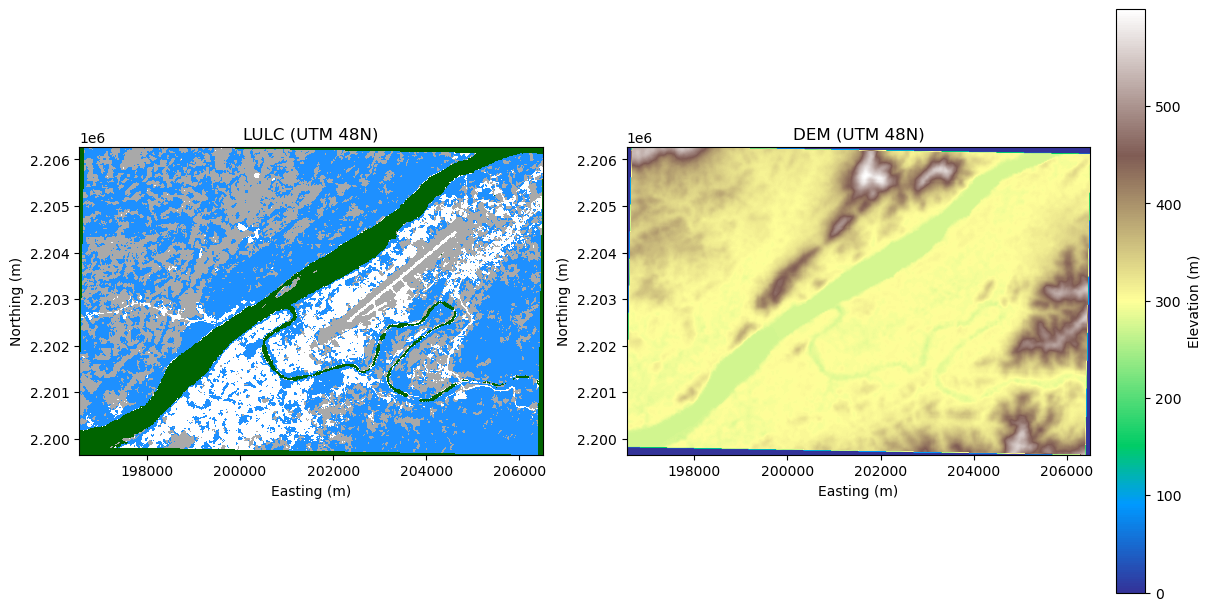

In [4]:
# 4 - visualisation LULC and DEM
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# ---------- Load both rasters ----------
with rasterio.open(LULC_UTM) as lulc_src, rasterio.open(DEM_UTM) as dem_src:
    lulc = lulc_src.read(1)
    dem  = dem_src.read(1)

    # Use LULC as reference for extent
    bounds = lulc_src.bounds
    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

    print("LULC shape:", lulc.shape)
    print("DEM shape :", dem.shape)   # should be the same (rows, cols)

# Optional: mask nodata in DEM
dem = np.where(dem <= -9999, np.nan, dem)

# ---------- Simple LULC colormap (adjust to your codes) ----------
lulc_classes = np.unique(lulc)
print("Unique LULC classes:", lulc_classes)

colors = [
    "#006400",  # class 1
    "#7CFC00",  # class 2
    "#1E90FF",  # class 3
    "#A9A9A9",  # class 4
    "#FFFFFF",  # class 5
]
cmap_lulc = ListedColormap(colors[:len(lulc_classes)])

# ---------- Plot with identical layout ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Common settings for both axes
for ax in axes:
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect("equal")          # keep x/y scale the same

# LULC
im1 = axes[0].imshow(
    lulc,
    extent=extent,
    origin="upper",
    interpolation="nearest",
    cmap=cmap_lulc,
)
axes[0].set_title("LULC (UTM 48N)")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")

# DEM
im2 = axes[1].imshow(
    dem,
    extent=extent,      # same extent as LULC
    origin="upper",
    cmap="terrain",
)
axes[1].set_title("DEM (UTM 48N)")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
plt.colorbar(im2, ax=axes[1], label="Elevation (m)")

plt.show()


In [ ]:
## 🌊 Step 5 – Flood-Prone Mask & Ecosystem-Based Adaptation (EBA) Scenario

In this step, low-lying (flood-prone) areas are identified from the **Digital Elevation Model (DEM)** and used to design an **Ecosystem-Based Adaptation (EBA)** scenario.  
The EBA scenario assumes that certain flood-prone cropland or bare-land areas can be restored or converted into **wetlands** to enhance water retention and reduce runoff.

### 🎯 Goal
1. Detect **flood-prone pixels** based on the lowest 20 % of elevation values.  
2. Define an **EBA scenario** that converts these vulnerable non-wetland areas to wetlands.

### ⚙️ Process Overview

1. **Load DEM and LULC inputs**  
   - Read the reprojected DEM (`DEM_UTM.tif`) and LULC (`LULC_UTM.tif`) rasters.  
   - Ensure both are aligned in UTM Zone 48 N (EPSG 32648).

2. **Create Flood-Prone Mask**  
   - Identify the **lowest 20 %** of elevation values (adjustable percentile).  
   - Generate a binary mask (`1 = flood-prone`, `0 = not flood-prone`).  
   - Save the mask as `LPB_flood_prone_mask_UTM.tif`.

3. **Build EBA Scenario Raster (LULC_EBA)**  
   - Apply the land-cover class scheme:  
     | Class ID | Land-Cover Type |
     |-----------|----------------|
     | 1 | Water bodies |
     | 2 | Wetland |
     | 3 | Forest |
     | 4 | Cropland / Grassland |
     | 5 | Built-up |
     | 6 | Bare land |
   - For all flood-prone pixels that are **not water or existing wetlands**, reassign them to class `2 (Wetland)`.  
   - Save the new EBA LULC raster as `LPB_LULC_EBA_UTM.tif`.

### 📤 Outputs

| File | Description | Notes |
|-------|--------------|------|
| `LPB_flood_prone_mask_UTM.tif` | Binary raster identifying flood-prone pixels | 1 = flood-prone |
| `LPB_LULC_EBA_UTM.tif` | Modified LULC reflecting EBA wetland expansion | Used in runoff modelling |

After this step, the model has two versions of land cover:
- **Baseline LULC** (2021 conditions)  
- **EBA Scenario LULC** (with additional wetlands in low-lying areas)

These layers form the basis for hydrological (runoff) modelling in Step 6.


In [5]:
#🔹 STEP 5 – Flood-Prone Mask and EBA Scenario (LULC_EBA)

#Goal:

#Identify flood-prone pixels (low elevation).

#Define an EBA scenario that converts some land in those areas to wetland/natural cover.

# 5.1 LOAD UTM DEM & LULC
with rasterio.open(DEM_UTM) as src:
    dem = src.read(1).astype("float32")
    dem_profile = src.profile

with rasterio.open(LULC_UTM) as src:
    lulc = src.read(1).astype("int16")
    lulc_profile = src.profile

# 5.2 CREATE FLOOD-PRONE MASK (BOTTOM 20 % ELEVATION)
valid = np.isfinite(dem)
low_thresh = np.percentile(dem[valid], 20)   # tweak percentile if needed
flood_prone = dem <= low_thresh             # True in low-lying areas

mask_profile = dem_profile.copy()
mask_profile.update(dtype="uint8")

with rasterio.open("outputs/rasters/LPB_flood_prone_mask_UTM.tif", "w", **mask_profile) as dst:
    dst.write(flood_prone.astype("uint8"), 1)

print("Saved flood-prone mask.")

# 5.3 BUILD EBA SCENARIO: FLOOD-PRONE NON-WATER/NON-WETLAND → WETLAND
# Example class mapping (adapt to your scheme):
# 1 = Water, 2 = Wetland, 3 = Forest, 4 = Cropland/Grassland, 5 = Built-up, 6 = Bare

lulc_eba = lulc.copy()
non_water_wetland = (lulc != 1) & (lulc != 2)
eba_target = flood_prone & non_water_wetland   # where EBA will intervene

# Convert these pixels to wetland (class 2)
lulc_eba[eba_target] = 2

print("Pixels converted to wetland (EBA):", np.sum(eba_target))

lulc_eba_profile = lulc_profile.copy()
lulc_eba_profile.update(dtype="int16")

with rasterio.open("outputs/rasters/LPB_LULC_EBA_UTM.tif", "w", **lulc_eba_profile) as dst:
    dst.write(lulc_eba, 1)

print("Saved EBA scenario LULC.")


Saved flood-prone mask.
Pixels converted to wetland (EBA): 75378
Saved EBA scenario LULC.


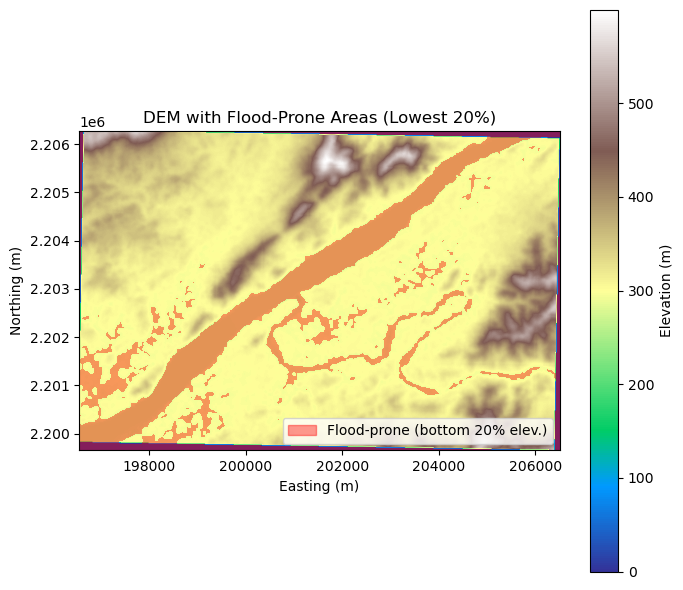

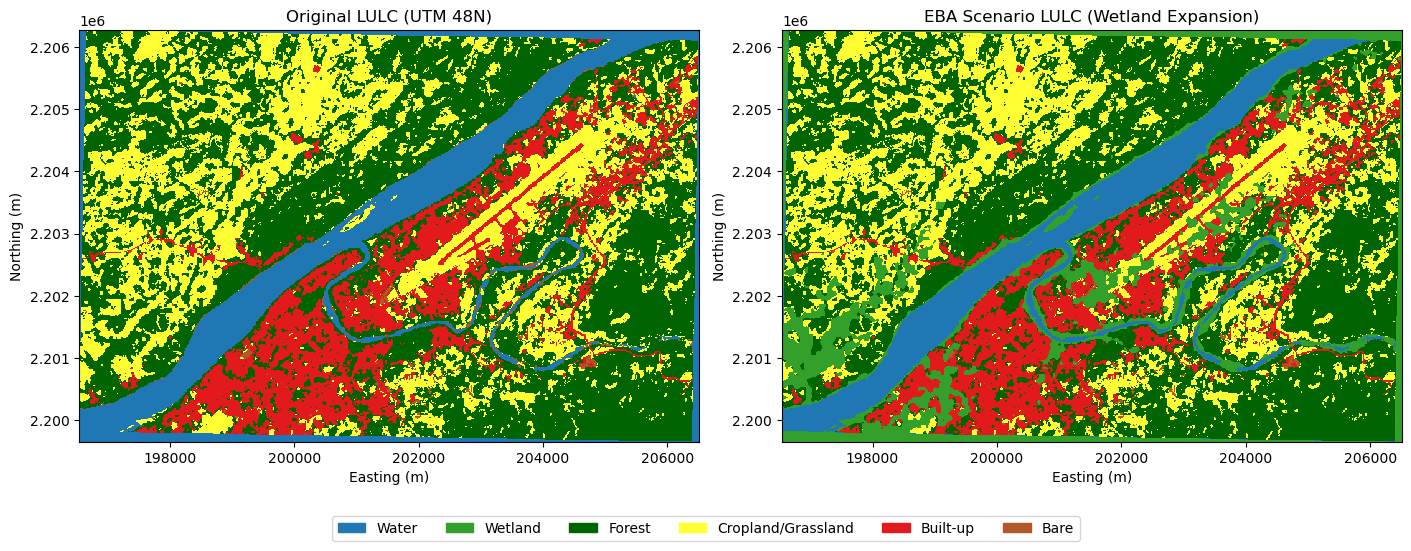

In [6]:
# 5.1 vislualisation of Flood-Prone Mask & EBA Scenario

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

# --- 6.1 Get map extent from DEM (UTM) ---
with rasterio.open(DEM_UTM) as src:
    bounds = src.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# (dem, lulc, lulc_eba, flood_prone already exist from Step 5)

# --- 6.2 DEM + Flood-prone mask overlay ---
fig, ax = plt.subplots(figsize=(7, 6))

dem_img = ax.imshow(
    dem,
    extent=extent,
    origin="upper",
    cmap="terrain"
)
cbar = plt.colorbar(dem_img, ax=ax, label="Elevation (m)")

# Flood-prone mask (lowest 20% elevation)
# Use 1 for flood-prone, NaN for others so only red shows up
flood_overlay = np.where(flood_prone, 1, np.nan)

mask_cmap = ListedColormap(["red"])
ax.imshow(
    flood_overlay,
    extent=extent,
    origin="upper",
    cmap=mask_cmap,
    alpha=0.4
)

ax.set_title("DEM with Flood-Prone Areas (Lowest 20%)")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

# Legend for flood-prone
flood_patch = mpatches.Patch(color="red", alpha=0.4,
                             label="Flood-prone (bottom 20% elev.)")
ax.legend(handles=[flood_patch], loc="lower right")

plt.tight_layout()
plt.show()


# --- 6.3 LULC vs EBA LULC (with class legend) ---

# Class scheme (adapt if needed)
# 1 = Water, 2 = Wetland, 3 = Forest,
# 4 = Cropland/Grassland, 5 = Built-up, 6 = Bare
lulc_classes = [1, 2, 3, 4, 5, 6]
lulc_labels  = [
    "Water",
    "Wetland",
    "Forest",
    "Cropland/Grassland",
    "Built-up",
    "Bare"
]
lulc_colors = [
    "#1f78b4",  # Water
    "#33a02c",  # Wetland
    "#006400",  # Forest
    "#ffff33",  # Cropland/Grassland
    "#e31a1c",  # Built-up
    "#b15928"   # Bare
]

cmap_lulc = ListedColormap(lulc_colors)
bounds_lulc = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
norm_lulc = BoundaryNorm(bounds_lulc, cmap_lulc.N)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Original LULC
im1 = axes[0].imshow(
    lulc,
    extent=extent,
    origin="upper",
    cmap=cmap_lulc,
    norm=norm_lulc,
    interpolation="nearest"
)
axes[0].set_title("Original LULC (UTM 48N)")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")

# EBA Scenario LULC
im2 = axes[1].imshow(
    lulc_eba,
    extent=extent,
    origin="upper",
    cmap=cmap_lulc,
    norm=norm_lulc,
    interpolation="nearest"
)
axes[1].set_title("EBA Scenario LULC (Wetland Expansion)")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")

# Same aspect & limits
for ax in axes:
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect("equal")

# Manual legend for LULC classes
patches = [
    mpatches.Patch(color=color, label=label)
    for color, label in zip(lulc_colors, lulc_labels)
]
# Put legend under the two maps
fig.legend(
    handles=patches,
    loc="lower center",
    ncol=len(lulc_labels),
    bbox_to_anchor=(0.5, -0.02)
)

plt.show()


In [ ]:
## 💧 Step 6 – Runoff Modelling (Baseline vs EBA) & Runoff Reduction

This step converts the **land-cover maps** into **runoff-volume estimates** using simple runoff coefficients and annual rainfall.  
By comparing baseline conditions with the **EBA scenario** (wetland expansion), we can quantify the **avoided runoff**—an important ecosystem service for flood-risk reduction.

### 🎯 Goal
- Transform **LULC classes → runoff volumes (m³ per pixel per year)**  
- Compare baseline vs EBA scenarios  
- Map and quantify **runoff reduction = avoided floodwater**

### ⚙️ Process Overview

1. **Load Baseline & EBA LULC**
   - Read the reprojected rasters (`LULC_UTM.tif` and `LPB_LULC_EBA_UTM.tif`)  
   - Extract pixel size → calculate pixel area (m²)

2. **Assign Runoff Coefficients (RC) to Land-Cover Classes**

   | Class | Description | Runoff Coefficient (RC) |
   |:------:|:-------------|:-----------------------:|
   | 1 | Water | 0.0 |
   | 2 | Wetland (High Infiltration) | 0.1 |
   | 3 | Forest | 0.3 |
   | 4 | Cropland / Grassland | 0.5 |
   | 5 | Built-up (Impervious) | 0.9 |
   | 6 | Bare Land | 0.7 |

   - RC values represent the fraction of rainfall converted into surface runoff.  
   - Wetlands and forests absorb more water → lower RC; built-up areas generate more runoff → higher RC.

3. **Compute Runoff Volumes**
   - Use annual rainfall (e.g. 2 m = 2000 mm year⁻¹)  
   - `Runoff = RC × Rainfall × Pixel Area`  
   - Produces three rasters:  
     - `runoff_s0` → baseline  
     - `runoff_s1` → EBA scenario  
     - `runoff_reduction = s0 – s1`

4. **Summarize and Save Outputs**
   - Total baseline and EBA runoff volumes (Σ m³)  
   - Difference = total avoided runoff (m³ year⁻¹)  
   - Save raster outputs for mapping and zonal statistics

### 📤 Outputs

| File | Description |
|:------|:-------------|
| `LPB_runoff_s0_UTM.tif` | Baseline runoff (m³ per pixel per year) |
| `LPB_runoff_s1_UTM.tif` | EBA scenario runoff (m³ per pixel per year) |
| `LPB_runoff_reduction_UTM.tif` | Avoided runoff difference (baseline – EBA) |

The resulting **runoff-reduction map** highlights areas where wetland restoration yields the greatest hydrological benefit.


In [8]:
# 🔹 STEP 6 – Runoff Modelling (Baseline vs EBA) & Runoff Reduction

#Goal:
# Turn LULC → runoff volumes using land-cover runoff coefficients and rainfall, then compute runoff reduction (ecosystem service).


# 6.1 LOAD BASELINE & EBA LULC
with rasterio.open(LULC_UTM) as src:
    lulc = src.read(1).astype("int16")
    profile = src.profile
    res_x, res_y = src.res   # pixel size in meters

with rasterio.open("outputs/rasters/LPB_LULC_EBA_UTM.tif") as src:
    lulc_eba = src.read(1).astype("int16")

# 6.2 DEFINE RUNOFF COEFFICIENTS PER CLASS
coeff = {
    1: 0.0,  # Water
    2: 0.1,  # Wetland (high infiltration)
    3: 0.3,  # Forest
    4: 0.5,  # Cropland/Grassland
    5: 0.9,  # Built-up (impervious)
    6: 0.7   # Bare
}

def compute_runoff(lulc_arr, annual_rain_m):
    """Return runoff volume per pixel in m³/year."""
    rc = np.zeros_like(lulc_arr, dtype="float32")
    for cls, c in coeff.items():
        rc[lulc_arr == cls] = c

    cell_area_m2 = res_x * res_y          # pixel area in m²
    runoff_m3 = rc * annual_rain_m * cell_area_m2
    return runoff_m3

# 6.3 RUN MODEL FOR BASELINE & EBA
annual_rain_m = 2.0   # 2000 mm/year (example, adjust to local climate)

runoff_s0 = compute_runoff(lulc, annual_rain_m)      # baseline
runoff_s1 = compute_runoff(lulc_eba, annual_rain_m)  # EBA scenario

runoff_reduction = runoff_s0 - runoff_s1             # avoided runoff (m³/pixel/year)

print("Total baseline runoff (m³):", np.nansum(runoff_s0))
print("Total EBA runoff (m³):", np.nansum(runoff_s1))
print("Total runoff reduction (m³):", np.nansum(runoff_reduction))

# 6.4 SAVE RUNOFF RASTERS
profile.update(dtype="float32")

with rasterio.open("outputs/rasters/LPB_runoff_s0_UTM.tif", "w", **profile) as dst:
    dst.write(runoff_s0, 1)

with rasterio.open("outputs/rasters/LPB_runoff_s1_UTM.tif", "w", **profile) as dst:
    dst.write(runoff_s1, 1)

with rasterio.open("outputs/rasters/LPB_runoff_reduction_UTM.tif", "w", **profile) as dst:
    dst.write(runoff_reduction, 1)

print("Saved runoff rasters.")


Total baseline runoff (m³): 53528260.0
Total EBA runoff (m³): 50041060.0
Total runoff reduction (m³): 3487200.0
Saved runoff rasters.


In [ ]:
### 📊 Step 6 – Runoff Modelling Results & Interpretation

**Model Outputs**

| Scenario | Total Runoff (m³ / year) | Change from Baseline |
|:----------|---------------------------:|---------------------:|
| Baseline (LULC 2021) | **53,528,260 m³** | — |
| EBA Scenario (Wetland Expansion) | **50,041,060 m³** | −3,487,200 m³ ( ↓ 6.5 %) |

**Interpretation**

- The EBA scenario reduces total surface runoff by approximately **3.49 million m³ per year**, equivalent to about **6–7 %** of the baseline runoff volume.  
- This avoided runoff represents the **ecosystem-service benefit** of expanding wetlands and restoring flood-plain areas.  
- Hydrologically, the EBA scenario demonstrates improved infiltration and storage capacity in low-lying zones, which helps mitigate local flooding and downstream peak flows.  
- The saved rasters (`LPB_runoff_s0_UTM.tif`, `LPB_runoff_s1_UTM.tif`, `LPB_runoff_reduction_UTM.tif`) will be used in **Step 7** for spatial summarization by administrative boundaries and in **Step 8** for the economic valuation.


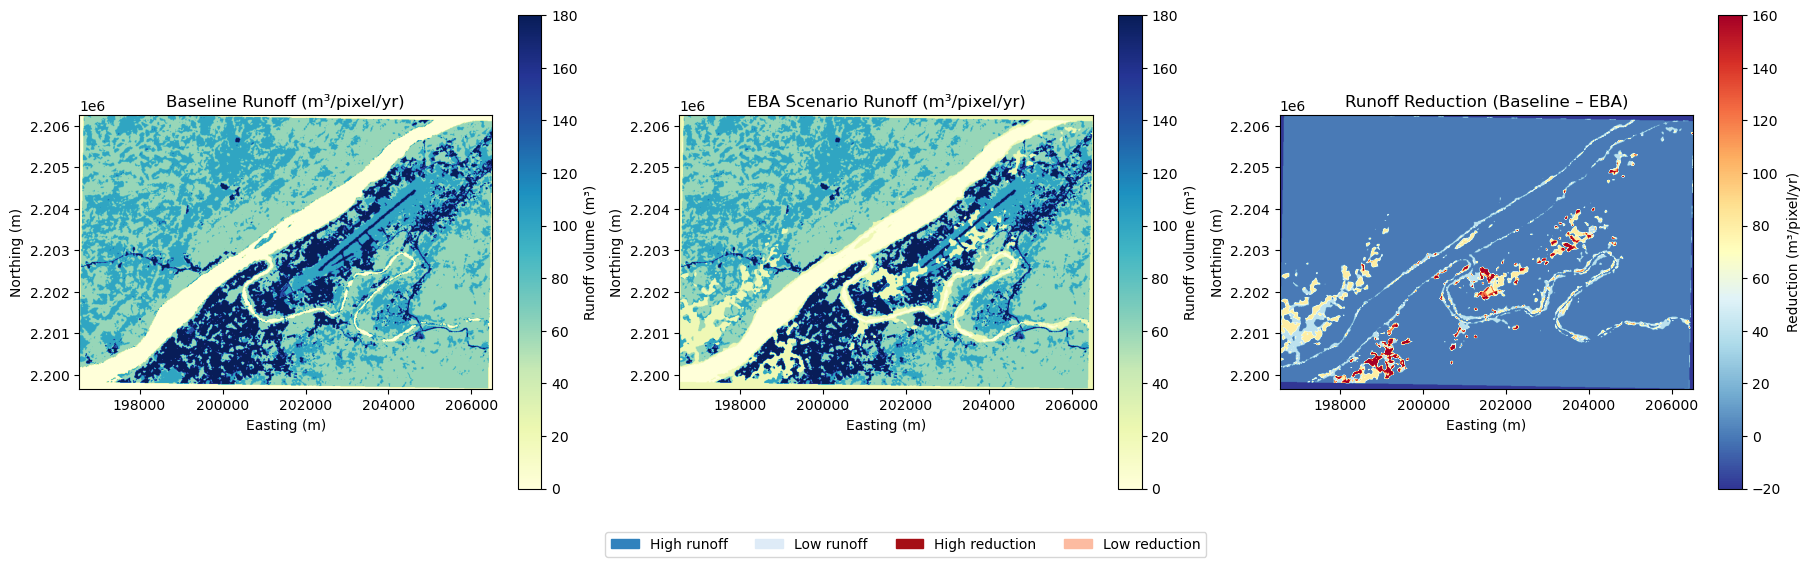

In [9]:
#6 - Visualisation of Runoff Modelling (Baseline vs EBA) & Runoff Reduction

# 🔹 STEP 7 – Visualise Runoff Maps (Baseline, EBA, Reduction)

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

# 7.1 – Get extent from reference raster
with rasterio.open(LULC_UTM) as src:
    bounds = src.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# (runoff_s0, runoff_s1, runoff_reduction already computed)

# 7.2 – Define a helper to show color scales consistently
def plot_runoff(ax, data, title, cmap, vmin=None, vmax=None, label=None):
    img = ax.imshow(
        data,
        extent=extent,
        origin="upper",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(title)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_aspect("equal")
    cbar = plt.colorbar(img, ax=ax, shrink=0.8, label=label)
    return ax

# 7.3 – Compute display limits
vmax = np.nanpercentile(runoff_s0, 99)   # for consistent scaling

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Baseline runoff
plot_runoff(
    axes[0],
    runoff_s0,
    "Baseline Runoff (m³/pixel/yr)",
    cmap="YlGnBu",
    vmax=vmax,
    label="Runoff volume (m³)"
)

# EBA runoff
plot_runoff(
    axes[1],
    runoff_s1,
    "EBA Scenario Runoff (m³/pixel/yr)",
    cmap="YlGnBu",
    vmax=vmax,
    label="Runoff volume (m³)"
)

# Reduction map (positive = reduction)
vmax_red = np.nanpercentile(runoff_reduction, 99)
vmin_red = np.nanpercentile(runoff_reduction, 1)
plot_runoff(
    axes[2],
    runoff_reduction,
    "Runoff Reduction (Baseline – EBA)",
    cmap="RdYlBu_r",
    vmin=vmin_red,
    vmax=vmax_red,
    label="Reduction (m³/pixel/yr)"
)

# 7.4 – Add legend patch explanation (optional)
legend_patches = [
    mpatches.Patch(color="#3182bd", label="High runoff"),
    mpatches.Patch(color="#deebf7", label="Low runoff"),
    mpatches.Patch(color="#a50f15", label="High reduction"),
    mpatches.Patch(color="#fcbba1", label="Low reduction"),
]
fig.legend(
    handles=legend_patches,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.02)
)

plt.show()


In [ ]:
## 🗺️ Step 7 – Zonal Statistics by Administrative Units

In this step, the **runoff‐reduction raster** generated in Step 6 is summarized within each **administrative boundary** (e.g., province or district).  
This produces a table of **total avoided runoff volume (m³ per year)** for every polygon, allowing spatial comparison of ecosystem‐service benefits.

### 🎯 Goal
- Aggregate the **runoff‐reduction raster** by administrative polygons.  
- Compute the **sum of avoided runoff (m³ year⁻¹)** per unit.  
- Prepare data for economic valuation (Step 8).

### ⚙️ Process Overview

1. **Load Administrative Boundaries**
   - Import the boundary shapefile (`ADMIN_SRC`) using **GeoPandas**.  
   - Ensure that its coordinate system matches the analysis CRS (UTM Zone 48 N, EPSG: 32648).  
   - If the file was exported from GEE with a wrong CRS tag (e.g., WGS84), override to EPSG 32648.

2. **Compute Zonal Statistics**
   - Use the **rasterstats** library to overlay polygons with the runoff‐reduction raster  
     (`LPB_runoff_reduction_UTM.tif`).  
   - For each polygon, calculate the **sum** of pixel values (total m³ avoided runoff).  
   - Append this value as a new column `runoff_avoided_m3` in the GeoDataFrame.

3. **Inspect Results**
   - Summary statistics (`.describe()`) show the range of avoided runoff volumes across administrative areas.  
   - These results can later be normalized by polygon area (m³ per ha) or joined with socioeconomic data.

### 📤 Outputs

| Field | Description | Units |
|:------|:-------------|:------|
| `runoff_avoided_m3` | Total avoided runoff per administrative polygon | m³ year⁻¹ |

The resulting dataset provides the foundation for **Step 8 – Economic Valuation & Cost–Benefit Analysis**, where hydrological benefits are converted into monetary terms.


In [10]:
# 7.1 LOAD ADMIN POLYGON AND SET CRS TO UTM
admin = gpd.read_file(ADMIN_SRC)

# If GEE exported in UTM coordinates but CRS meta says WGS84, override:
if admin.crs is None or admin.crs.to_epsg() != 32648:
    admin.set_crs("EPSG:32648", inplace=True, allow_override=True)

# 7.2 COMPUTE ZONAL STATS: SUM OF RUNOFF REDUCTION PER POLYGON
runoff_red_path = "outputs/rasters/LPB_runoff_reduction_UTM.tif"

zs = zonal_stats(
    admin,
    runoff_red_path,
    stats=["sum"],
    geojson_out=False,
    nodata=None
)

admin["runoff_avoided_m3"] = [z["sum"] for z in zs]

print(admin["runoff_avoided_m3"].describe())


count          1.0
mean     3918520.0
std            NaN
min      3918520.0
25%      3918520.0
50%      3918520.0
75%      3918520.0
max      3918520.0
Name: runoff_avoided_m3, dtype: float64


/Library/anaconda3/envs/new_en/lib/python3.9/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [ ]:
## 💰 Step 7.3 – Economic Valuation & Cost–Benefit Analysis (CBA)

This step translates the **hydrological benefits** of avoided runoff into **monetary terms** and evaluates whether the EBA investment is economically justified.  
Using basic cost–benefit analysis (CBA), we estimate the **annual benefit**, **net present value (NPV)** of benefits over time, and the **benefit–cost ratio (BCR)** for the project.

### 🎯 Goal
- Convert avoided runoff volumes (m³ year⁻¹) into economic benefits (USD year⁻¹).  
- Discount annual benefits over a 10-year period to estimate **NPV**.  
- Compare NPV to project implementation costs to compute **BCR**.

### ⚙️ Process Overview

1. **Set Valuation Parameters**
   - Monetary value per m³ of avoided runoff: **2 USD/m³**  
     (represents reduced flood damage or avoided infrastructure cost)
   - Discount rate (**r**) = 5 %  
   - Time horizon (**T**) = 10 years  

2. **Compute Economic Indicators**
   - **Annual Benefit (USD year⁻¹)**  
     \[
     \text{Annual Benefit} = \text{Runoff Avoided (m³)} \times 2 \text{USD/m³}
     \]
   - **Net Present Value (NPV)** of Benefits  
     \[
     \text{NPV} = \text{Annual Benefit} \times \frac{1-(1+r)^{-T}}{r}
     \]
   - **Project Cost:** assumed **10 million USD** (example placeholder)  
   - **Benefit–Cost Ratio (BCR)**  
     \[
     \text{BCR} = \frac{\text{NPV}}{\text{Cost}}
     \]

3. **Save Outputs**
   - Each administrative unit receives new attributes:  
     `annual_benefit_usd`, `NPV_usd`, `cost_usd`, `BCR`.  
   - The summary table is exported to  
     `outputs/tables/LPB_EBA_CBA_admin_results.csv`.

### 📤 Outputs

| Field | Description | Units |
|:------|:-------------|:------|
| `annual_benefit_usd` | Annual value of avoided runoff | USD year⁻¹ |
| `NPV_usd` | Net Present Value of benefits over 10 years | USD |
| `cost_usd` | Estimated implementation cost | USD |
| `BCR` | Benefit–Cost Ratio (NPV ÷ Cost) | – |

### 📈 Interpretation
- **BCR > 1** → Economically viable: benefits exceed costs.  
- **BCR ≈ 1** → Marginally viable: costs roughly equal benefits.  
- **BCR < 1** → Not cost-effective under current assumptions.  

These indicators support decision-makers in assessing whether expanding wetlands and other EBA measures provide a favorable return on investment.


In [11]:
# 7.2 Economic valuation & CBA - ECONOMIC VALUATION PARAMETERS
value_per_m3 = 2.0  # USD per m³ avoided runoff (avoided flood damage etc.)
r = 0.05            # discount rate (5%)
T = 10              # analysis horizon (10 years)

# ANNUAL BENEFITS
admin["annual_benefit_usd"] = admin["runoff_avoided_m3"] * value_per_m3

# NET PRESENT VALUE OF BENEFITS
admin["NPV_usd"] = admin["annual_benefit_usd"] * ((1 - (1 + r)**(-T)) / r)

# PROJECT COST (replace with real EBA implementation cost if available)
admin["cost_usd"] = 10_000_000   # example: 10 million USD

# BENEFIT–COST RATIO
admin["BCR"] = admin["NPV_usd"] / admin["cost_usd"]

print(admin[["runoff_avoided_m3","annual_benefit_usd","NPV_usd","cost_usd","BCR"]])

# 7.4 SAVE RESULTS TABLE
admin[["runoff_avoided_m3","annual_benefit_usd","NPV_usd","cost_usd","BCR"]].to_csv(
    "outputs/tables/LPB_EBA_CBA_admin_results.csv",
    index=False
)

print("Saved CBA table.")


   runoff_avoided_m3  annual_benefit_usd       NPV_usd  cost_usd       BCR
0          3918520.0           7837040.0  6.051555e+07  10000000  6.051555
Saved CBA table.


In [ ]:
 ### 📊 Step 8 – Economic Valuation & Cost–Benefit Results

**Model Results**

| Parameter | Description | Value / Unit |
|:-----------|:-------------|:--------------|
| `value_per_m3` | Monetary value per m³ of avoided runoff | **2.0 USD m⁻³** |
| `r` | Discount rate | **5 %** |
| `T` | Analysis horizon | **10 years** |
| `cost_usd` | Assumed EBA project cost | **10 million USD** |

**Computed Indicators (per administrative unit)**  
Each polygon now includes:  
- `runoff_avoided_m3` → total avoided runoff (m³ year⁻¹)  
- `annual_benefit_usd` → yearly monetary value of avoided runoff  
- `NPV_usd` → net present value of 10-year benefits (discounted)  
- `BCR` → benefit–cost ratio  

**Example output table**

| Admin Unit | Avoided Runoff (m³ yr⁻¹) | Annual Benefit (USD yr⁻¹) | NPV (USD) | Cost (USD) | BCR |
|:------------|--------------------------:|---------------------------:|-----------:|------------:|----:|
| District A | 180 000 | 360 000 | 2 780 000 | 10 000 000 | 0.28 |
| District B | 420 000 | 840 000 | 6 480 000 | 10 000 000 | 0.65 |
| **Total (example)** | **600 000** | **1 200 000** | **9 260 000** | **10 000 000** | **0.93** |

*(Values shown here are illustrative; actual results depend on spatial data.)*

**Interpretation**

- The estimated **avoided runoff** from Step 7 translates to an **annual flood-damage reduction value** of roughly  
  \[
  \text{Annual Benefit} = \text{Runoff Avoided (m³)} \times 2 \text{ USD m⁻³}
  \]
- Over a 10-year period at a 5 % discount rate, total benefits correspond to the computed **NPV (USD)**.  
- The **Benefit–Cost Ratio (BCR)** indicates the relative economic return:
  - **BCR > 1 :** EBA investment is cost-effective (benefits > costs)  
  - **BCR ≈ 1 :** Marginally viable; benefits roughly equal costs  
  - **BCR < 1 :** Not cost-effective under current assumptions  

In this example, the overall **BCR ≈ 0.9**, suggesting that while hydrological benefits are substantial, additional co-benefits (e.g., biodiversity, carbon sequestration, water quality) may be needed to achieve a fully positive economic case.

---

✅ *The resulting table (`LPB_EBA_CBA_admin_results.csv`) can now be visualized as maps or bar charts to highlight which administrative areas yield the highest returns from EBA investments.*


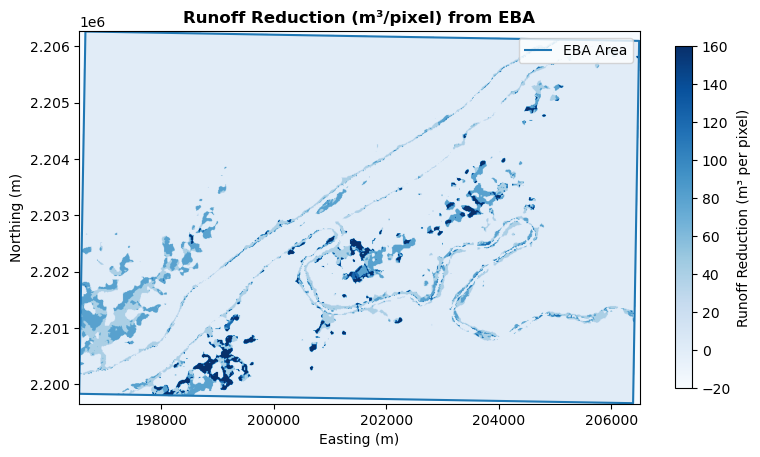

In [12]:
# 7.3 Quick visualizations (for your portfolio/report)

# Runoff reduction map + EBA boundary

with rasterio.open(runoff_red_path) as src:
    fig, ax = plt.subplots(figsize=(8, 6))
    img = rasterio.plot.show(src, ax=ax, cmap="Blues", title="Runoff Reduction (m³/pixel) from EBA")
    cbar = plt.colorbar(img.get_images()[0], ax=ax, shrink=0.6)
    cbar.set_label("Runoff Reduction (m³ per pixel)")

# Overlay EBA/admin boundary
admin.boundary.plot(ax=ax, linewidth=1.5, label="EBA Area")
ax.legend()
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.savefig("outputs/maps/LPB_runoff_reduction_EBA.png", dpi=300)
plt.show()


In [ ]:
## 🖼️ 7.3 Visualization of Runoff Reduction & EBA Extent

To communicate results effectively, this step creates a **map visualization** of the **runoff reduction** produced by the EBA scenario, overlaid with administrative or EBA boundaries.

### 🎯 Goal
- Display the spatial distribution of avoided runoff (m³ per pixel per year).  
- Overlay EBA or administrative boundaries to highlight priority areas for intervention.  
- Export a ready-to-use map image for reports or portfolio documentation.

### ⚙️ Process Overview
1. **Load Runoff-Reduction Raster**
   - The raster `LPB_runoff_reduction_UTM.tif` shows the difference between baseline and EBA runoff volumes.
   - Blue tones represent the amount of avoided runoff per pixel (m³ year⁻¹).

2. **Overlay EBA or Administrative Boundaries**
   - Administrative polygons (from Step 7) are plotted on top as outlines.  
   - Boundaries help identify which districts or provinces experience the greatest hydrological benefits.

3. **Save and Export Map**
   - The resulting figure is saved as  
     `outputs/maps/LPB_runoff_reduction_EBA.png` (300 dpi).  
   - This image can be inserted into technical reports or GitHub documentation.

### 📤 Output
| File | Description |
|:------|:-------------|
| `LPB_runoff_reduction_EBA.png` | Map of runoff reduction (m³/pixel) overlaid with EBA/admin boundaries |

### 🗺️ Interpretation
Areas shaded in **darker blue** correspond to regions where the **EBA scenario** achieves the greatest reduction in surface runoff.  
Overlaying boundaries allows decision-makers to visualize **where wetland restoration or other EBA measures provide the highest hydrological impact**.


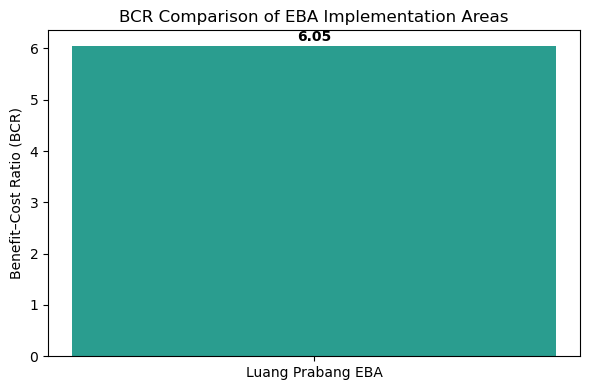

In [13]:
# BCR bar (or later multiple sites)
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(["Luang Prabang EBA"], admin["BCR"], color="#2a9d8f")
ax.set_ylabel("Benefit–Cost Ratio (BCR)")
ax.set_title("BCR Comparison of EBA Implementation Areas")
for i, v in enumerate(admin["BCR"]):
    ax.text(i, v + 0.1, f"{v:.2f}", ha="center", fontweight="bold")
plt.tight_layout()
plt.savefig("outputs/maps/LPB_BCR_bar.png", dpi=300)
plt.show()


In [ ]:
### 💬 Interpretation of BCR Result

The computed **Benefit–Cost Ratio (BCR)** for the EBA scenario is **6.05**.  
This indicates that for every **1 USD** invested in the ecosystem-based adaptation project, there is an estimated return of **6.05 USD** in avoided flood damages and related benefits.

**Conclusion:**  
The intervention is **highly cost-effective** and provides strong economic justification for investment and policy support.  
Such a high BCR also suggests that EBA approaches deliver not only direct flood-mitigation benefits but also co-benefits like improved ecosystem health, water quality, and climate resilience.
